In [1]:
# import utility modules
import pandas as pd
import numpy as np
import configparser
import os

import numpy as np
import pandas as pd
from scipy.optimize import minimize
from helpers.helper_classes import AddFeatureNames, Gene_SPCA
from helpers.helper_functions import get_data_pev
from joblib import dump, load

import matplotlib.pyplot as plt

In [3]:
# Read config.ini file
config = configparser.ConfigParser()
config.read('config.ini')

os.chdir(config['PATH']['ROOT_DIR'])

# Read data
data = load(config['PATH']['DATA_DIR'] + '/microarray-data-dict.lib')

# Read parameters
SEED = config.getint('PARAMS', 'SEED')
N_COMPONENTS = config.getint('PARAMS', 'N_COMPONENTS')

In [4]:
X = data['gravier']['none']['X_train']

In [5]:
get_data_pev(X, n_components = N_COMPONENTS)

# pca = get_spca(0)
# pca.fit(X, verbose = 0)
# pca_X = pca.transform(X)
# _, R = np.linalg.qr(pca_X)
# total_var = sum(R[i][i]**2 for i in range(R.shape[0]))

# nonzero_counter = 999999999
# l1_cur = 800
# nonzero_arr = []
# explained_var_arr = []

# while nonzero_counter > 200:
#     spca_cur = get_spca(l1_cur)
#     spca_cur.fit(X, verbose = 0)
#     print('-'*50)
#     print(f"l1 = {l1_cur}")

#     x_spca_cur = spca_cur.transform(X)
#     _, R_cur = np.linalg.qr(x_spca_cur)
#     explained_var_leading = R_cur[0][0]**2

#     PEV = explained_var_leading / total_var
#     nonzero_counter = spca_cur.nonzero

#     nonzero_arr.append(nonzero_counter)
#     explained_var_arr.append(PEV)


#     print(f'Explained variance: {PEV} ')
#     print(f"nonzero: {spca_cur.nonzero}, total:{spca_cur.totloadings}")
#     # Count number of zero rows in spca_cur.loadings
#     zero_rows = sum(np.count_nonzero(spca_cur.loadings[i,:]) == 0 for i in range(spca_cur.loadings.shape[0]))
#     print(f"zero loading columns: {zero_rows}, total genes: {spca_cur.loadings.shape[0]}")

#     l1_cur += 50


TypeError: get_gene_spca() got an unexpected keyword argument 'n_components'

In [19]:
# Loop over values of lambda with jumps of 20
# First total variance is saved
    # Calculate explained variance

# Function that returns gene_SPCA object with parameter l1
def get_gene_spca(l1):
    spca_obj = Gene_SPCA(max_iter = 10000, l1 = l1)
    return spca_obj

def get_data_pev(X, n_components = 30):
    """ 
    Function that returns the explained variance of the first principal component for a single dataset versus 
    the number of non-zero loadings / genes

    Returns:
    - nonzero_columns_arr: array with number of columns with a non-zero influence on the first principal component
    - nonzero_loadings_arr: array with number of non-zero loadings of 'B' matrix
    - PEV_var_arr: array with explained variance of first principal component
    """

    # First obtain total variance
    pca = get_gene_spca(0, n_components = n_components)
    _, R = np.linalg.qr(pca.fit_transform(X, verbose = 0))
    total_var = sum(R[i][i]**2 for i in range(R.shape[0]))

    # Initialize values for loop
    nonzero_cnt = 999999999
    l1_cur = 0
    nonzero_loadings_arr = []
    nonzero_columns_arr = []
    PEV_var_arr = []

    while nonzero_cnt > 200:

        # Obtain and fit spca object
        spca_cur = get_gene_spca(l1_cur)
        X_spca_cur = spca_cur.fit_transform(X, verbose = 0)

        # Obtain PEV
        _, R_cur = np.linalg.qr(X_spca_cur)
        explained_var_leading = R_cur[0][0]**2
        PEV = explained_var_leading / total_var

        # Count number of nonzero loadings and columns
        zero_rows = sum(np.count_nonzero(spca_cur.loadings[i,:]) == 0 for i in range(spca_cur.loadings.shape[0]))
        nonzero_cnt = X.shape[1] - zero_rows
        
        # Append values to arrays
        nonzero_columns_arr.append(nonzero_cnt)
        nonzero_loadings_arr.append(spca_cur.nonzero)
        PEV_var_arr.append(PEV)

        # Update l1_cur
        l1_cur += 20
    
    return nonzero_columns_arr, nonzero_loadings_arr, PEV_var_arr






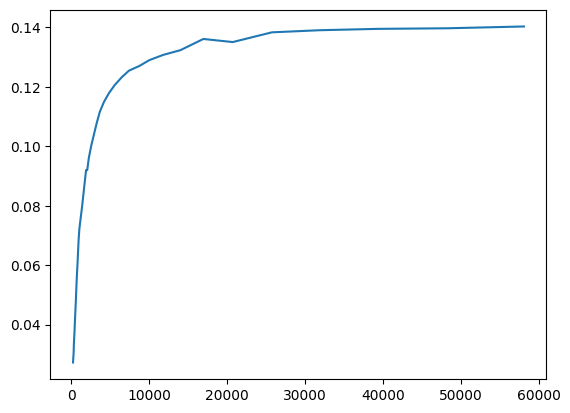

In [11]:
# Plot nonzero_arr on x axis vs explained_var_arr on y axis
plt.plot(nonzero_arr, explained_var_arr)

In [17]:
# spca_cur.fit(X, verbose = 1)

print(spca_cur.loadings)

# Count number of zero rows in spca_cur.loadings
zero_rows = 0
for i in range(spca_cur.loadings.shape[0]):
    if np.count_nonzero(spca_cur.loadings[i,:]) == 0:
        zero_rows += 1
print(zero_rows)
print(spca_cur.loadings.shape[0])

[[ 0.09150103  0.          0.         ...  0.          0.
   0.        ]
 [ 0.19401706  0.         -0.         ... -0.          0.
   0.        ]
 [ 0.09585162  0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.         -0.         ... -0.         -0.
  -0.        ]
 [ 0.          0.         -0.         ... -0.         -0.
  -0.        ]
 [ 0.          0.         -0.         ... -0.         -0.
  -0.        ]]
2707
2905


In [53]:
X_pca = spca2.transform(X)
# X_pca
q, r = np.linalg.qr(X_pca)
r_sum = sum([r[i][i] ** 2 for i in range(r.shape[0])])
r_sum

854585.55989654

In [57]:
X_pca

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
42,-16.473661,24.062878,-42.759138,48.255035,-17.617491,-41.881759,23.690921,-2.490027,38.222572,-7.212068,36.757253,-23.661106,12.051573,-27.984199,11.929424,-9.069064,7.712620,-1.763035,-39.111772,62.128663
66,8.174794,2.114994,47.726624,27.878534,-19.647535,-13.936487,20.452667,-10.626750,24.340598,-10.568895,46.484546,19.471846,-6.077744,12.461225,15.912921,32.714610,-31.175601,10.407045,75.701881,41.528277
10,-46.302236,-90.556235,0.829259,-6.753396,-19.523520,20.507766,-11.445554,17.899727,6.147647,23.165415,4.630668,-19.836907,-27.433939,-31.917362,-15.470877,-5.021656,-22.270759,32.430155,-35.856649,-4.568680
41,21.706979,32.777931,-31.909737,-25.254573,28.165183,7.781386,-4.756863,14.732359,9.707926,-5.546479,0.071190,11.236568,8.133522,-6.646714,3.150328,-18.725575,0.607966,9.644798,8.144524,0.024643
44,13.924549,-16.538470,-14.761541,5.231607,17.211757,-9.449427,29.160989,9.908283,20.149282,-6.823380,-31.550542,19.109773,-9.493173,13.395716,21.684099,4.634281,-8.642876,-15.086035,9.419357,-5.930563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,-29.136621,-21.142270,-20.009353,-28.793188,39.395605,13.414453,-6.740880,2.597302,-13.201438,0.278773,7.047152,10.326395,-12.545226,23.185868,2.102063,-6.639207,9.571617,8.699316,11.422493,0.373863
55,-5.967873,-25.157358,-39.767923,14.234829,4.636317,-16.020152,21.903256,2.298364,22.472371,8.781420,-21.022362,0.486348,-22.823616,22.494406,1.346300,-24.478198,7.327986,8.796923,2.859189,-9.241101
70,5.690352,33.261284,-6.708788,10.120563,3.104935,-7.641707,20.514516,5.224012,14.198954,42.296428,-3.139375,-12.592113,25.372523,1.122732,0.778862,4.180464,9.270901,4.793085,-18.192000,22.915308
25,-159.966889,76.393327,94.885312,27.188031,33.919686,-100.075551,-72.427584,60.241306,12.071200,14.795208,-41.567200,2.209779,-7.052159,-6.311049,2.622913,-3.051982,1.191344,-4.549466,2.348702,-13.779303


In [56]:
data['nakayama']['pca']['X_train']


,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15,pca16,pca17,pca18,pca19
42,16.477926,-24.078501,-42.781633,-48.467921,17.588653,41.659460,23.720883,0.719771,-37.719784,-3.652126,34.982270,-22.384846,13.200823,26.875842,-10.144102,-4.830065,-9.133227,4.334678,-31.968151,22.553432
66,-8.177756,-2.112978,47.749464,-27.897541,19.625181,13.869385,20.445724,10.546824,-25.897313,-6.779674,49.252916,21.439565,-6.997197,-13.280405,-24.802436,40.407054,27.117649,14.233159,81.683934,61.602947
10,46.302880,90.555472,0.809228,6.714340,19.397077,-20.534231,-11.555544,-18.466456,-0.977374,22.152031,4.685572,-17.672435,-27.598891,32.443904,22.957113,5.883489,20.845904,32.633298,-30.536513,40.809825
41,-21.707186,-32.786181,-31.907437,25.269430,-28.121673,-7.385706,-4.710339,-14.904861,-10.233188,-3.523380,0.208443,11.940841,8.519087,6.445963,-0.477245,-18.412883,14.539424,1.659910,1.832454,1.797984
44,-13.916725,16.532896,-14.776334,-5.437748,-17.148740,9.032284,28.933716,-10.878288,-19.232876,-4.536857,-33.241009,19.545940,-5.683071,-11.847960,-25.988307,5.856459,12.593774,-17.953442,4.074051,11.749941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,29.135978,21.141497,-20.006925,28.855437,-39.378607,-13.161328,-6.728273,-2.268052,12.638712,-1.412556,6.696501,10.215588,-13.022137,-23.318861,-2.125561,-9.576153,-2.440781,9.967541,12.323928,-10.077494
55,5.963405,25.141514,-39.741136,-14.108881,-4.857225,16.295027,21.682055,-1.615313,-22.031571,12.121305,-18.932360,-0.189395,-23.992704,-18.108127,1.916079,-30.681292,13.553710,9.547250,7.837845,-25.274167
70,-5.685620,-33.257841,-6.728768,-10.239039,-3.094663,7.703875,20.301625,-6.160965,-5.240412,41.037402,-1.905045,-13.351274,28.012669,0.400462,-2.672478,-4.224916,-9.548783,8.058363,-14.717716,17.709750
25,159.965764,-76.388870,94.894289,-27.210018,-33.928544,100.165393,-72.318605,-60.078442,-10.490367,17.154217,-40.677160,1.999466,-6.936254,6.616654,-1.462540,-2.905312,0.108726,-5.054623,-0.084530,-5.643968


In [37]:
X_pca

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
61,-12.800383,5.485750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,-7.308678,6.874201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66,-11.039944,3.907272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,19.072396,7.369476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,21.927365,9.836106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,18.454847,5.648707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,1.874078,-3.058442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,19.919736,2.590212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60,-33.108854,4.816542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71,-44.602720,6.467148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
